<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

Source : https://www.kaggle.com/c/quora-question-pairs 

# Business Problem 

# Description 
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

# Data fields

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. 

# Problem Statement

- Identify which questions asked on Quora are duplicates of questions that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

# Type of Machine Leaning Problem 

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

# 1. Exploratory Data analysis

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 1.1 Reading data and basic stats 

In [16]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape)

Number of data points: (404290, 6)


In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 1.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

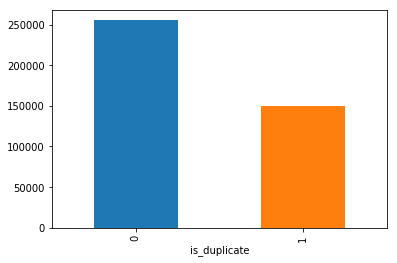

In [14]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [17]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

- The number of duplicates(similar) words are less compared to non-duplicates words

In [23]:
print('Total number of question pairs for training:\n   {}'.format(len(df)))

Total number of question pairs for training:
   404290


In [28]:
print(' {}% of Question pairs are not Similar (is_duplicate = 0):\n '.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n  Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

 63.08% of Question pairs are not Similar (is_duplicate = 0):
 

  Question pairs are Similar (is_duplicate = 1):
   36.92%


# 1.2.2 Number of unique questions 

In [67]:
#To check repeated questions in qid1

print("lenght of qid1 is : {}".format(df.qid1.value_counts().shape))
qs_morethan_onetime = np.sum(df.qid1.value_counts() > 1)
print("\nNumber of unique questions that appear more than one time : {}".format(qs_morethan_onetime))

df.qid1.value_counts().head(5)

lenght of qid1 is : (290654,)

Number of unique questions that appear more than one time : 54073


8461     50
14110    48
25984    47
20628    47
1749     47
Name: qid1, dtype: int64

- question1_id's are repeated many times hence there are repeated questions in question1
- 8461 th question has repeated 50 times
- question1 has 290654 unique questions

In [66]:
print("lenght of qid2 is : {}".format(df.qid2.value_counts().shape))
qs_morethan_onetime = np.sum(df.qid2.value_counts() > 1)
print("\nNumber of unique questions that appear more than one time : {}".format(qs_morethan_onetime))

df.qid2.value_counts().head(5) #To check repeated questions in qid2

lenght of qid2 is : (299364,)

Number of unique questions that appear more than one time : 45631


30782    120
2559     115
4044     100
2561      71
17978     66
Name: qid2, dtype: int64

- Question 2 has 299364 unique questions
- 30782 th Question has repeated many times

In [56]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

Total number of  Unique Questions are: 537933



In [73]:
qs_morethan_onetime = np.sum(qids.value_counts() > 1)


print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals.head()

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



2559     157
30782    120
4044     111
2561      88
14376     79
dtype: int64

- By combining all the unique questions in qid1 and qid2, 2559 th question has repeated 157 times.

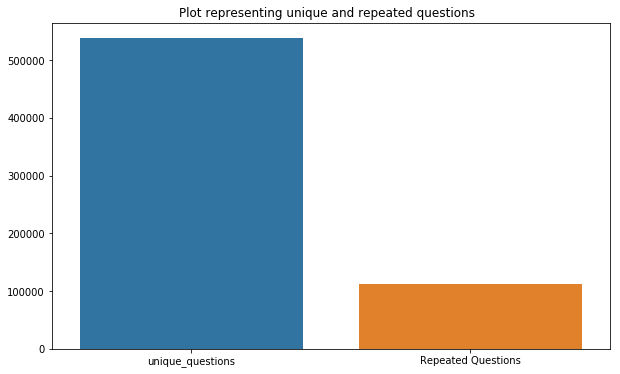

In [58]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

- Morethan 5 lakh unique questions
- around 1 lakh repeated questions

# 1.2.3 Checking for Duplicates 

In [68]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


# 1.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



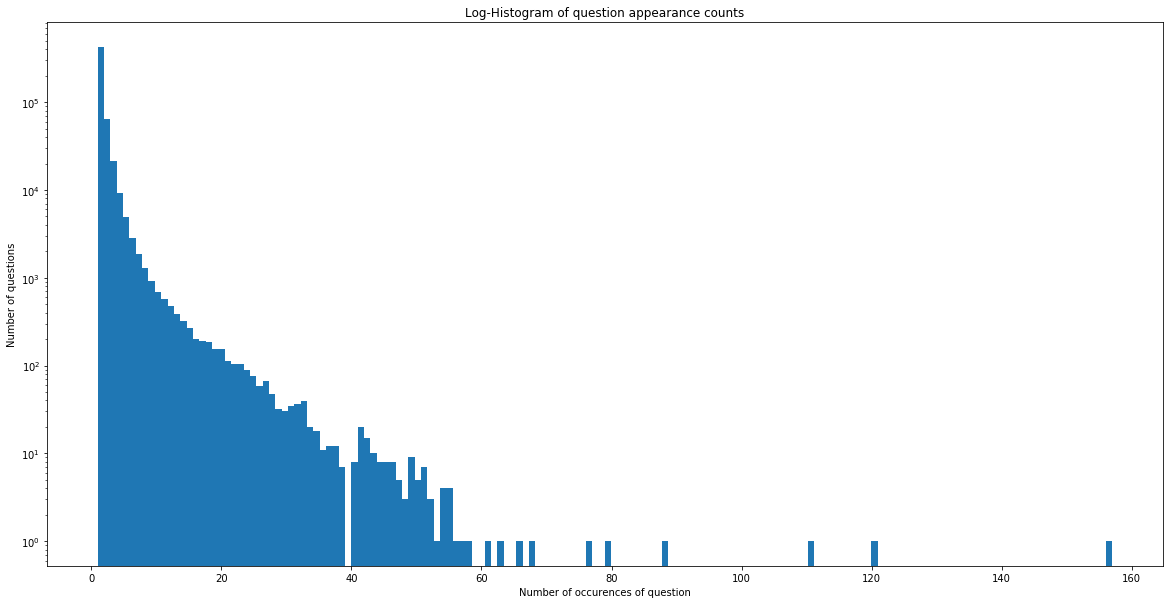

In [75]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

- The number of questions that occur only once are more.
- only one question that occur 120 times.

# 1.2.5 Checking for NULL values

In [76]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2

In [77]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# 1.3 Basic Feature Extraction (before cleaning) 

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [85]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# 1.3.1 Analysis of some of the extracted features 

- Here are some questions have only one single words.

In [86]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 1.3.1.1 Feature: word_share </h4>

C:\Users\varma\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\varma\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


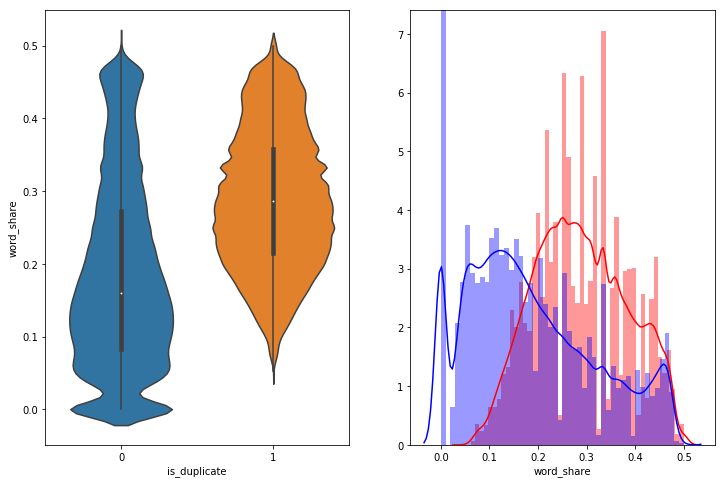

In [87]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The less the overlap between these two distributions the better is the feature. In this case there is some overlap which means word_share feature is somewhat useful.

<h4> 1.3.1.2 Feature: word_Common </h4>

C:\Users\varma\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\varma\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


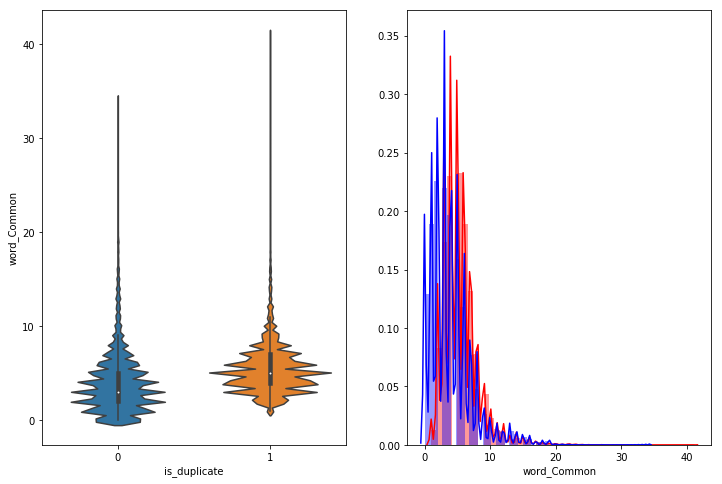

In [88]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.

# 1.4 Preprocessing of Text 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [89]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 1.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
        
- __Stop_Word__ : stop words as per NLTK.

- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2    #stop words count<br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [92]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [93]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>1.5.1 Analysis of extracted features </h3>

 <h4> 1.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [132]:
df_duplicate = df[df['is_duplicate'] == 1]
print(df_duplicate.shape)

df_duplicate

(149263, 21)


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,0.666656,0.571420,0.888879,0.799992,...,0.705878,1.0,0.0,0.0,17.0,83,77,73,73,0.160920
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,0.499975,0.499975,0.599988,0.428565,...,0.444440,1.0,0.0,2.0,8.0,71,64,61,67,0.354839
11,11,23,24,how do i read and find my youtube comments,how can i see all my youtube comments,1,0.666644,0.499988,0.599988,0.599988,...,0.555549,1.0,1.0,1.0,8.5,81,76,76,74,0.538462
12,12,25,26,what can make physics easy to learn,how can you make physics easy to learn,1,0.999975,0.999975,0.666644,0.499988,...,0.749991,1.0,0.0,1.0,7.5,92,85,88,89,0.756757
13,13,27,28,what was your first sexual experience like,what was your first sexual experience,1,0.999967,0.749981,0.999967,0.999967,...,0.857131,0.0,1.0,1.0,6.5,100,94,94,100,0.974359
15,15,31,32,what would a trump presidency mean for current...,how will a trump presidency affect the student...,1,0.374995,0.299997,0.166664,0.142855,...,0.235293,0.0,0.0,1.0,16.5,61,57,55,56,0.217391
16,16,33,34,what does manipulation mean,what does manipulation means,1,0.499975,0.499975,0.999950,0.999950,...,0.749981,0.0,1.0,0.0,4.0,98,98,98,96,0.931034
18,18,37,38,why are so many quora users posting questions ...,why do people ask quora questions which can be...,1,0.571420,0.499994,0.199996,0.166664,...,0.357140,1.0,1.0,1.0,13.5,72,61,61,59,0.148649
20,20,41,42,why do rockets look white,why are rockets and boosters painted white,1,0.666644,0.499988,0.499975,0.333322,...,0.428565,1.0,1.0,2.0,6.0,81,66,63,65,0.333333
29,29,59,60,how should i prepare for ca final law,how one should know that he she completely pre...,1,0.749981,0.428565,0.749981,0.499992,...,0.461535,0.0,1.0,5.0,10.5,91,63,65,71,0.564103


In [140]:
p = np.dstack([df_duplicate["qid1"], df_duplicate["qid2"]])
p

array([[[    11,     12],
        [    15,     16],
        [    23,     24],
        ...,
        [  1931,  16773],
        [537926, 537927],
        [ 18840, 155606]]], dtype=int64)

In [142]:
p.flatten()

array([    11,     12,     15, ..., 537927,  18840, 155606], dtype=int64)

In [145]:
p.flatten().shape #qid1(149263) + qid2(149263) = 298526

(298526,)

In [102]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, encoding = 'utf-8', delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [146]:
# reading the text files and removing the Stop Words:
from os import path
from wordcloud import WordCloud, STOPWORDS

d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33194892


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


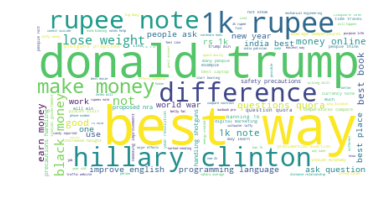

In [147]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


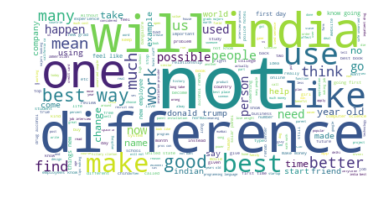

In [148]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 1.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

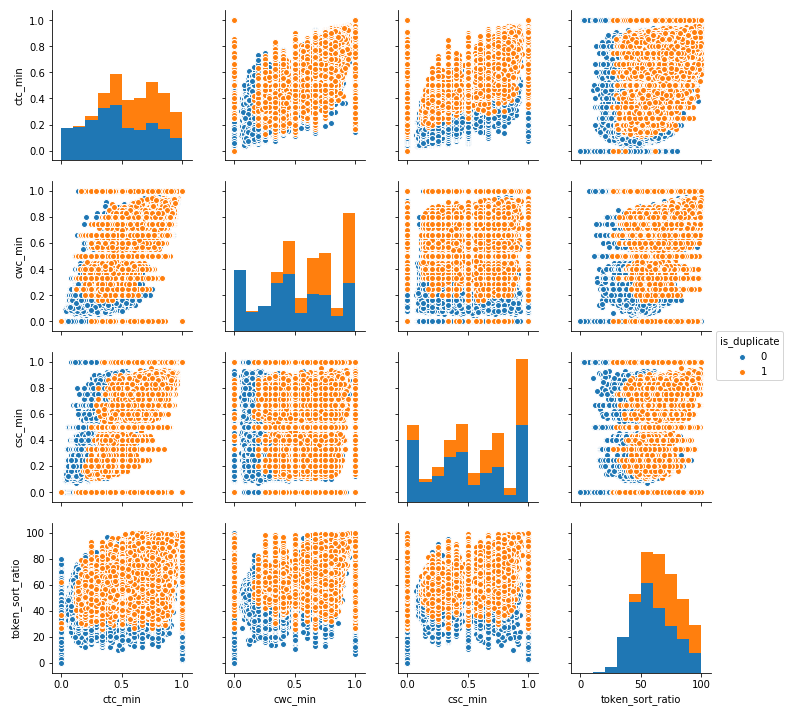

In [149]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

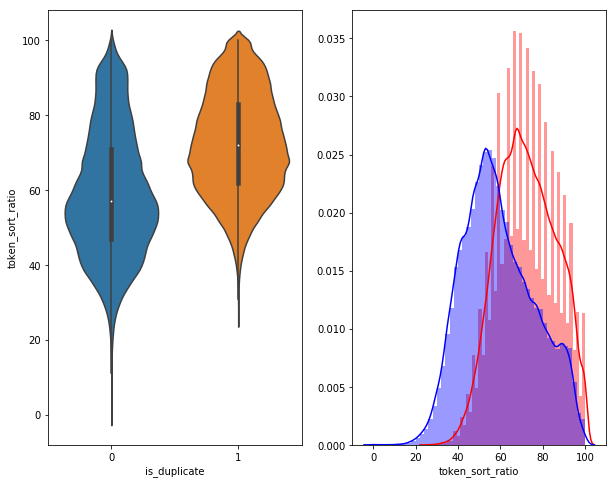

In [150]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>1.5.2 Visualization </h3>

In [154]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [155]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.075s...
[t-SNE] Computed neighbors for 5000 samples in 0.984s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.430s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 5.601s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 3.900s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 4.847s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 4.286s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

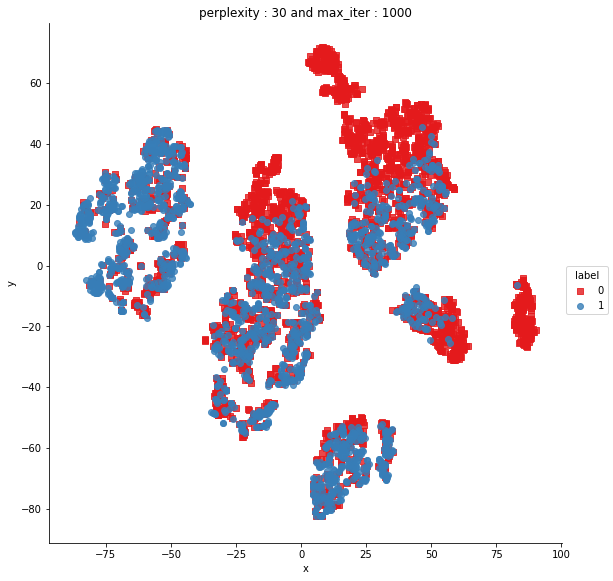

In [156]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [157]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.341s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 20.175s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 10.637s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 9.354s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 9.690s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.00092

In [158]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# 1.6 Modeling on TFIDF vectorizer

In [206]:
# Load Basic Features
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [207]:
print("Columns : ",df_basic_feature.columns)
print("\nNumber of columns : ",len(df_basic_feature.columns))

df_basic_feature.head(3)

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

Number of columns :  17


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


In [208]:
# Load Advance Features
df_advance_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [209]:
print("Columns : ",df_advance_features.columns)
print("\nNumber of columns : ",len(df_advance_features.columns))

df_advance_features.head(3)

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  21


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [210]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')
df_basic_advance_features.head(3)

,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


 <h4>Specifying target value i.e dependent value</h4>

In [211]:
target = df_basic_advance_features['is_duplicate'] #y

In [212]:
df_basic_advance_features.drop(['id','is_duplicate'], axis=1, inplace=True) #x
df_basic_advance_features.head(3)

,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


# 1.6.1 Random train test split

In [280]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df_basic_advance_features, target, test_size=0.3)

In [281]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 28)
Number of data points in test data : (121287, 28)


In [282]:
# Instanciate Tfidf Vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer_question1 = TfidfVectorizer()

question1_vectorized = tfidfVectorizer_question1.fit_transform(X_train['question1'].values.astype('U'))

question1_vectorized

<283003x57905 sparse matrix of type '<class 'numpy.float64'>'
	with 2821340 stored elements in Compressed Sparse Row format>

In [283]:
print("Length of the question1 features is : {}".format(len(tfidfVectorizer_question1.get_feature_names())))

Length of the question1 features is : 57905


In [284]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question2 = TfidfVectorizer()

question2_vectorized = tfidfVectorizer_question2.fit_transform(X_train['question2'].values.astype('U'))
question2_vectorized

<283003x53479 sparse matrix of type '<class 'numpy.float64'>'
	with 2857932 stored elements in Compressed Sparse Row format>

In [285]:
print("Length of the question2 features is : {}".format(len(tfidfVectorizer_question2.get_feature_names())))

Length of the question2 features is : 53479


<h4>Combining question1 and question2 vectorized for train data</h4>

In [286]:
from scipy.sparse import hstack
# Combine all the features in question1 and question2
questions = hstack((question1_vectorized,question2_vectorized))

In [287]:
X_train.drop(['question1','question2'], axis=1, inplace=True)

In [288]:
X_train = hstack((X_train, questions),format="csr",dtype='float64')

In [289]:
X_train.shape

(283003, 111410)

<h4>Test data</h4>

In [291]:
question1_vectorized_test = tfidfVectorizer_question1.transform(X_test['question1'].values.astype('U'))
question1_vectorized_test

<121287x57905 sparse matrix of type '<class 'numpy.float64'>'
	with 1198324 stored elements in Compressed Sparse Row format>

In [292]:
question2_vectorized_test = tfidfVectorizer_question2.transform(X_test['question2'].values.astype('U'))
question2_vectorized_test

<121287x53479 sparse matrix of type '<class 'numpy.float64'>'
	with 1217830 stored elements in Compressed Sparse Row format>

<h4>Combining question1 and question2 vectorized for test data</h4>

In [294]:
questions_test = hstack((question1_vectorized_test,question2_vectorized_test))

In [295]:
X_test.drop(['question1','question2'] , axis=1,inplace=True)

In [296]:
X_test = hstack((X_test,questions_test),format='csr',dtype='float64')

In [297]:
X_test.shape

(121287, 111410)

In [298]:
y_train.shape

(283003,)

In [299]:
y_test.shape

(121287,)

In [312]:
from collections import Counter
print("The number of duplicate and non duplicates in X_train : \n")
train_distr = Counter(y_train)
print(train_distr)
print("\n The number of duplicates and non duplicates in X_test : \n")
test_distr = Counter(y_test)
print(test_distr)

The number of duplicate and non duplicates in X_train : 

Counter({0: 178531, 1: 104472})

 The number of duplicates and non duplicates in X_test : 

Counter({0: 76496, 1: 44791})


- In train data the number of non duplicates(0) are more compared to duplicates(1).
- In test data also the number of non duplicates are more compared to duplicates.

In [318]:
train_len = len(y_train)
print("length of y_train:", train_len )
test_len = len(y_test)
print("length of y_test:", test_len )

length of y_train: 283003
length of y_test: 121287


In [315]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a random model (Finding worst-case log-loss) 

Log loss on Test Data using Random Model 0.8847368454038522


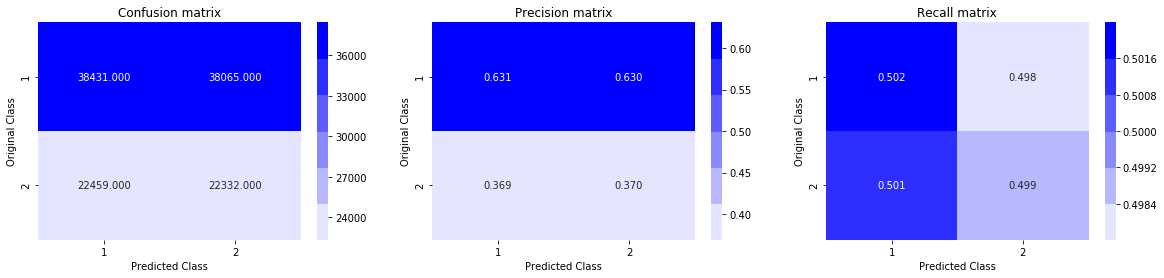

In [319]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.45924508947593023
For values of alpha =  0.0001 The log loss is: 0.4631930793477809
For values of alpha =  0.001 The log loss is: 0.45163990874990245
For values of alpha =  0.01 The log loss is: 0.44910049321940615
For values of alpha =  0.1 The log loss is: 0.4587608432136579
For values of alpha =  1 The log loss is: 0.4905038545322198
For values of alpha =  10 The log loss is: 0.5453506240986837


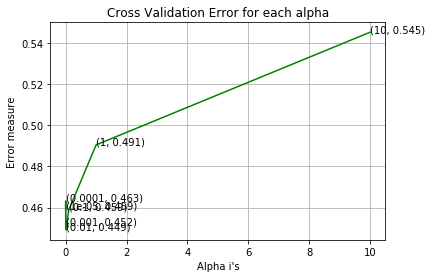

For values of best alpha =  0.01 The train log loss is: 0.45003863481660766
For values of best alpha =  0.01 The test log loss is: 0.44910049321940615
Total number of data points : 121287


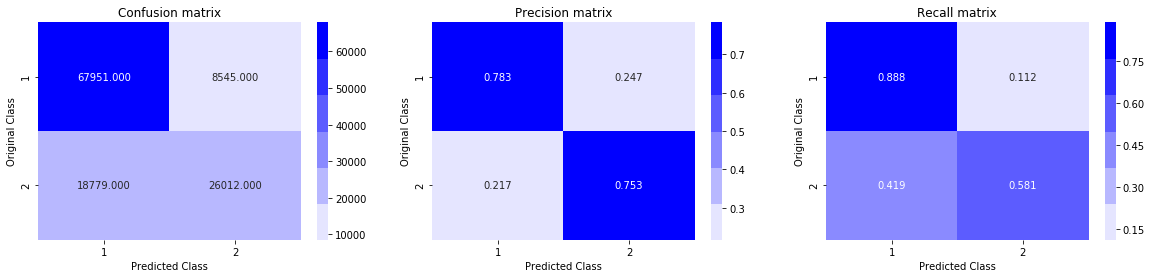

In [322]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.44647584409415964
For values of alpha =  0.0001 The log loss is: 0.48200407596358286
For values of alpha =  0.001 The log loss is: 0.5053746360144893
For values of alpha =  0.01 The log loss is: 0.5189890815040662
For values of alpha =  0.1 The log loss is: 0.499439139707632
For values of alpha =  1 The log loss is: 0.5798900264089147
For values of alpha =  10 The log loss is: 0.6436810231954488


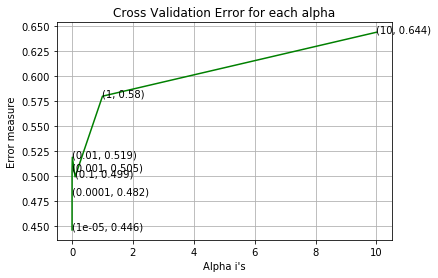

For values of best alpha =  1e-05 The train log loss is: 0.44648536746968953
For values of best alpha =  1e-05 The test log loss is: 0.44647584409415964
Total number of data points : 121287


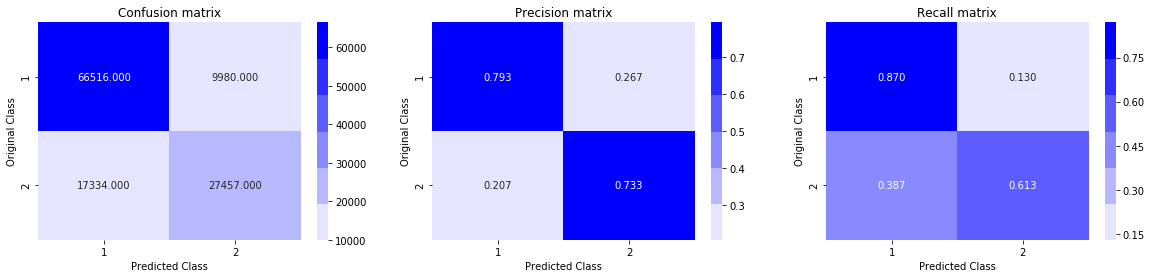

In [323]:
from sklearn.svm import SVC



# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost with hyperparameter tuning

In [326]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt

start = dt.datetime.now()

params = {'n_estimators' : [1,2,4,6,8,10,15,20,30,40,60],'learning_rate' :[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
param_grid = params

model = xgb.XGBClassifier(nthread=-1)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", cv=kfold)
random_search.fit(X_train,y_train)

# Summarize results

train_auc = random_search.cv_results_['mean_train_score']
train_auc_std = random_search.cv_results_['std_train_score']
test_auc = random_search.cv_results_['mean_test_score']
test_auc_std = random_search.cv_results_['std_test_score']
print("Best HyperParameter: ",random_search.best_params_)
print("Best Accuracy: %.2f%%"%(random_search.best_score_*100))
   
print("\nTimeTaken: ",dt.datetime.now() - start)

Best HyperParameter:  {'n_estimators': 30, 'learning_rate': 0.2}
Best Accuracy: -37.55%

TimeTaken:  0:11:10.446708


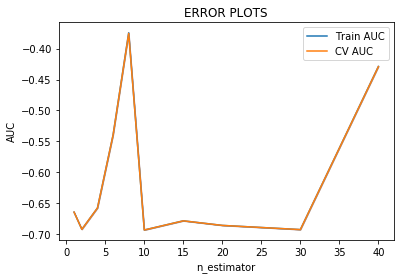

In [327]:
estimator = [1,2,4,6,8,10,15,20,30,40]
plt.plot(estimator, train_auc, label='Train AUC')
#reference: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(estimator,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(estimator, test_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(estimator,test_auc - test_auc_std,test_auc + test_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("n_estimator")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4035926728250636
For values of best alpha =  1e-05 The test log loss is: 0.40307298870475644
Total number of data points : 121287


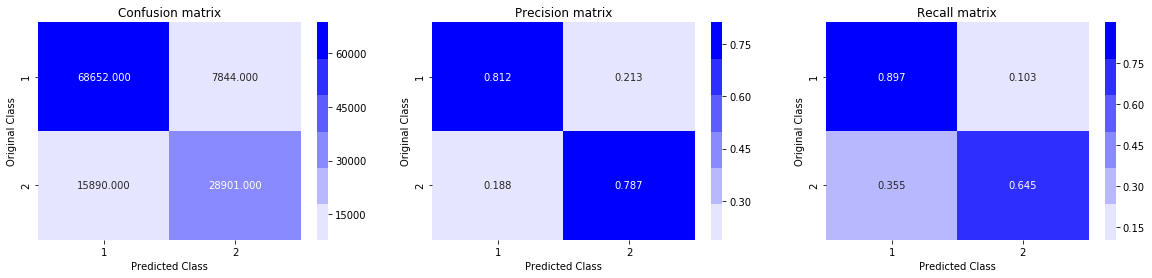

0:00:30.238292


In [339]:
from datetime import datetime
start = datetime.now()

xGBClassifier = xgb.XGBClassifier( 
                              learning_rate=0.1, 
                              n_estimators=30,
                              nthread=-1)
xGBClassifier.fit(X_train, y_train)

predict_y = xGBClassifier.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = xGBClassifier.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

print(datetime.now() - start)

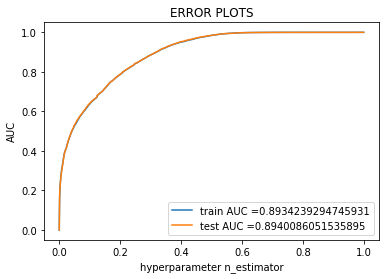

In [340]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

train_fpr, train_tpr, thresholds = roc_curve(y_train, xGBClassifier.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, xGBClassifier.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter n_estimator")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Conclusion

In [342]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = " Model Comparision "
x.field_names = ['Model', 'Various tokenizer', 'train log loss ','test Log Loss']
x.add_row(["Random model","TFIDF","NA","0.88473"])
x.add_row(["Logistic Regression","TFIDF","0.450","0.449"])
x.add_row(["Linear SVM","TFIDF","0.446","0.446"])
x.add_row(["xgboost","TFIDF","0.403","0.403"])
print(x)

+---------------------+-------------------+-----------------+---------------+
|        Model        | Various tokenizer | train log loss  | test Log Loss |
+---------------------+-------------------+-----------------+---------------+
|     Random model    |       TFIDF       |        NA       |    0.88473    |
| Logistic Regression |       TFIDF       |      0.450      |     0.449     |
|      Linear SVM     |       TFIDF       |      0.446      |     0.446     |
|       xgboost       |       TFIDF       |      0.403      |     0.403     |
+---------------------+-------------------+-----------------+---------------+
